<a href="https://colab.research.google.com/github/FairuzMaulidya/SC/blob/main/Salinan_PROJEK_FIX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Menyiapkan Augmentasi Data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# 2. Memuat Data
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/SC/ribuan/latih',  # Path data pelatihan
    target_size=(224, 224),
    batch_size=32,  # Sesuaikan batch size
    class_mode='sparse',
    shuffle=True  # Data dilatih dengan shuffle
)

validation_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/SC/ribuan/validasi',  # Path data validasi
    target_size=(224, 224),
    batch_size=32,  # Sesuaikan batch size
    class_mode='sparse',
    shuffle=False  # Validasi tidak perlu shuffle
)

# 3. Membuat Model dengan Transfer Learning (MobileNetV2)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Membekukan beberapa layer pertama base model (misalnya sampai layer ke-100)
for layer in base_model.layers[:100]:
    layer.trainable = False

# Membebaskan beberapa layer terakhir untuk fine-tuning
for layer in base_model.layers[100:]:
    layer.trainable = True

# Membangun model dengan lapisan tambahan
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Tambahkan regularisasi L2
x = Dropout(0.5)(x)  # Regularisasi dropout
x = Dense(10, activation='softmax')(x)  # Sesuaikan dengan jumlah kelas

# Final model
model = Model(inputs=base_model.input, outputs=x)

# 4. Kompilasi Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Menampilkan ringkasan model
model.summary()

# 5. Melatih Model
# 5. Melatih Model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10  # Jumlah epoch tetap
)

# Menyimpan Model
# Menentukan versi model
version = 7
model_filename = f'model_v{version}.h5'

# Menyimpan model
model.save(model_filename)
print(f"Model disimpan ke: {model_filename}")

Found 1920 images belonging to 10 classes.
Found 480 images belonging to 10 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 2,026,698 (7.73 MB)

 Non-trainable params: 396,544 (1.51 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1963s 32s/step - accuracy: 0.3618 - loss: 4.2905 - val_accuracy: 0.8792 - val_loss: 2.6682
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 679ms/step - accuracy: 0.8818 - loss: 2.6907 - val_accuracy: 0.9146 - val_loss: 2.4210
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 681ms/step - accuracy: 0.9517 - loss: 2.3665 - val_accuracy: 0.9583 - val_loss: 2.2472
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 678ms/step - accuracy: 0.9734 - loss: 2.2028 - val_accuracy: 0.9521 - val_loss: 2.1563
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 684ms/step - accuracy: 0.9858 - loss: 2.0668 - val_accuracy: 0.9646 - val_loss: 2.0431
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 684ms/step - accuracy: 0.9944 - loss: 1.9584 - val_accuracy: 0.9750 - val_loss: 1.9144
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 686ms/step - accuracy: 0.9885 - loss: 1.8725 - val_accuracy: 0.9792 - val_loss: 1.8011
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 689ms/step - accuracy: 0.9924 - loss: 1.7587 - val_accu

Model disimpan ke: model_v7.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 244ms/step - accuracy: 0.9821 - loss: 1.5070
Validation Loss: 1.4924
Validation Accuracy: 0.9896
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step


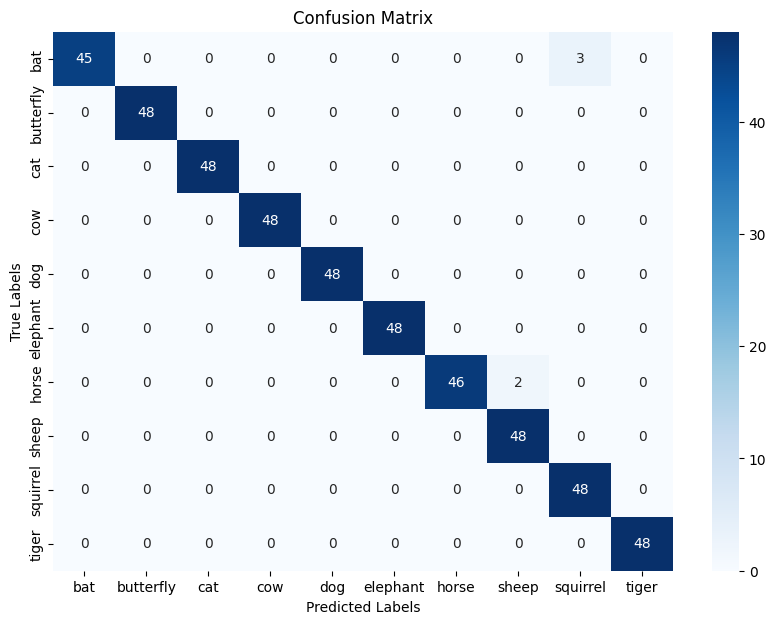

Classification Report:
              precision    recall  f1-score   support

         bat     1.0000    0.9375    0.9677        48
   butterfly     1.0000    1.0000    1.0000        48
         cat     1.0000    1.0000    1.0000        48
         cow     1.0000    1.0000    1.0000        48
         dog     1.0000    1.0000    1.0000        48
    elephant     1.0000    1.0000    1.0000        48
       horse     1.0000    0.9583    0.9787        48
       sheep     0.9600    1.0000    0.9796        48
    squirrel     0.9412    1.0000    0.9697        48
       tiger     1.0000    1.0000    1.0000        48

    accuracy                         0.9896       480
   macro avg     0.9901    0.9896    0.9896       480
weighted avg     0.9901    0.9896    0.9896       480

Error Rate: 0.0104


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 1. Mengevaluasi Model dengan Dataset Validasi
val_loss, val_accuracy = model.evaluate(validation_generator, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# 2. Mendapatkan Prediksi dan Label Asli
y_true = validation_generator.classes  # Label sebenarnya
y_pred_prob = model.predict(validation_generator, verbose=1)  # Prediksi probabilitas
y_pred = np.argmax(y_pred_prob, axis=1)  # Mengambil kelas dengan probabilitas tertinggi

# 3. Menghitung Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 4. Menampilkan Confusion Matrix Berwarna
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 5. Menghasilkan Laporan Klasifikasi (Precision, Recall, F1 Score)
target_names = list(validation_generator.class_indices.keys())  # Nama kelas
report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print("Classification Report:")
print(report)

# 6. Menghitung Error Rate
error_rate = 1 - val_accuracy
print(f"Error Rate: {error_rate:.4f}")

In [4]:
from ipywidgets import FileUpload, Image, VBox
from PIL import Image as PILImage
import io
import numpy as np
import tensorflow as tf

# Daftar kelas yang sesuai dengan model Anda
class_names = ['bat', 'butterfly', 'cat', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'squirrel', 'tiger']

# Load model (gunakan model Anda sendiri)
model = tf.keras.models.load_model('/content/model_v7.h5')

# Membuat widget untuk mengupload file
upload = FileUpload(accept='image/*', multiple=False)

# Membuat widget Image untuk menampilkan gambar dengan ukuran tampilan yang disesuaikan
image_widget = Image()

# Fungsi untuk memproses gambar setelah diupload
def process_uploaded_image(change):
    # Mendapatkan file yang diupload
    img_data = next(iter(upload.value.values()))['content']

    # Membuka gambar dengan PIL
    img = PILImage.open(io.BytesIO(img_data))

    # Menampilkan gambar yang diupload pada widget
    img_resized = img.resize((400, 400))  # Mengubah ukuran gambar sesuai keinginan
    img_bytes = io.BytesIO()
    img_resized.save(img_bytes, format='PNG')
    img_bytes.seek(0)

    image_widget.value = img_bytes.read()  # Update widget image dengan gambar yang sudah diubah ukurannya
    image_widget.width = 300  # Atur lebar tampilan gambar
    image_widget.height = 300  # Atur tinggi tampilan gambar

    # Mengubah ukuran gambar sesuai input model (224x224)
    img_resized_for_model = img.resize((224, 224))

    # Mengubah gambar menjadi array numpy
    img_array = np.array(img_resized_for_model)

    # Menambah dimensi batch
    img_array = np.expand_dims(img_array, axis=0)

    # Normalisasi (sesuai dengan model yang digunakan)
    img_array = img_array / 255.0

    # Melakukan prediksi
    classes = model.predict(img_array)

    # Mengidentifikasi kelas berdasarkan prediksi
    predicted_class = np.argmax(classes, axis=1)

    # Menampilkan nama kelas prediksi
    predicted_class_name = class_names[predicted_class[0]]
    print(f'Predicted Class: {predicted_class_name}')

# Menyambungkan fungsi dengan upload event
upload.observe(process_uploaded_image, names='value')

# Tampilkan widget upload dan gambar
display(VBox([upload, image_widget]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Class: squirrel
